# Isotropic elastic wave equation implementation on a staggered grid


In [ ]:
import devito as dv

In [ ]:
# Create a 3D grid
shape = (51, 51, 51)
extent = (500., 500., 500.)  # this is in metres
grid = dv.Grid(shape=shape, extent=extent)

# Vectorial form

One of the advantages of Devito is the high level symbolic API. This allows for straight forward generalisation of expressions between 2D and 3D. 


Leveraging the symbolic algebra capabilities of Devito enables concise, flexible specifications of equations. In this case, it's desirable to represent the isotropic elastic system of equations in the following form:


\begin{cases}
&\frac{dv}{dt} = \underline{\nabla} . \tau \\
&\frac{d \tau}{dt} = \lambda \text{diag}(\underline{\nabla} . \underline{v}) + \mu (\underline{\nabla} \underline{v} + (\underline{\nabla} \underline{v})^T)
\end{cases}


where in 3D, $\underline{v}$ is a vector valued function:

$\underline{v}(t, x, y, z) = (v_x(t, x, y, z), v_y(t, x, y, z), v_z(t, x, y, z))$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y, z) = \begin{bmatrix}\tau_{xx}(t, x, y, z) & \tau_{xy}(t, x, y, z)  & \tau_{xz}(t, x, y, z) \\\tau_{yx}(t, x, y, z) & \tau_{yy}(t, x, y, z) & \tau_{yz}(t, x, y, z)  \\\tau_{zx}(t, x, y, z) & \tau_{zy}(t, x, y, z) & \tau_{zz}(t, x, y, z)\end{bmatrix}$


We show in the following how to setup the elastic wave-equation form Devito's high-level tensorial types.

As $\underline{v}$ is a vector which varies in time, we represent it as a `VectorTimeFunction`.

In [ ]:
so = 4
to = 1

v = dv.VectorTimeFunction(name='v', grid=grid, space_order=so, time_order=to)
v

We can see that staggering is applied by default.

There is also a `TensorTimeFunction` to store $\tau$:

In [ ]:
τ = dv.TensorTimeFunction(name='tau', grid=grid, space_order=so, time_order=to)
τ

Note that staggering is also applied here by default. Furthermore, this tensor is symmetrical:

In [ ]:
τ[0, 1] is τ[1, 0]

Let's define our parameters. Whilst these will be constant for now, it is trivial to make them vary in space (as will be shown later). 

In [ ]:
vs = 1500.  # s-wave velocity in m/s
vp = 2500.  # p-wave velocity in m/s
ρ = 3000.  # density in kg/m^3

b = 1/ρ
μ = vs**2/ρ
λ = (vp**2/ρ) - 2*μ

With this, we can write our equations in the following way:

Firstly, for the velocity equation: $\frac{dv}{dt} = \underline{\nabla} . \tau$, we formulate it as follows:

In [ ]:
pde_v = v.dt - b * dv.div(τ)
pde_v

And for the stress equation: $\frac{d \tau}{dt} = \lambda \text{diag}(\underline{\nabla} . \underline{v}) + \mu (\underline{\nabla} \underline{v} + (\underline{\nabla} \underline{v})^T)$:

In [ ]:
pde_tau = τ.dt - λ * dv.diag(dv.div(v.forward)) - μ * (dv.grad(v.forward) + dv.grad(v.forward).T)
# pde_tau  # uncomment to print (may go off of page)


In [ ]:
# Time update 
u_v = dv.Eq(v.forward, dv.solve(pde_v, v.forward))
u_t = dv.Eq(τ.forward,  dv.solve(pde_tau, τ.forward))

We will need to create a source to inject into this field. For this we will import a `RickerSource` from the examples. Note that this is a thin wrapper around `SparseTimeFunction` with a prefilled time series.

In [ ]:
from examples.seismic import TimeAxis, RickerSource

t0, tn = 0., 400.
dt = 0.2*min(grid.spacing)/vp  # Courant number is 0.2
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.010, time_range=time_range)
src.coordinates.data[:] = 250.

# The source injection term
src_xx = src.inject(field=τ.forward[0, 0], expr=dt*src)
src_yy = src.inject(field=τ.forward[1, 1], expr=dt*src)
src_zz = src.inject(field=τ.forward[2, 2], expr=dt*src)

Now we create a Devito `Operator`. Note the order of arguments supplied to the operator - this corresponds to the order of these updates within the time loop.

In [ ]:
op = dv.Operator([u_v, u_t] + src_xx + src_yy + src_zz)
op(dt=dt)

With this, the wavefield can be rendered to show its 3D structure. We will choose the x normal stress field for this visualisation.

In [ ]:
# import numpy as np

# try:
#     import trame
# except ModuleNotFoundError:
#     ! pip install trame
# try:
#     import pyvista as pv
# except ModuleNotFoundError:
#     ! pip install pyvista
#     import pyvista as pv

# rendergrid = pv.UniformGrid()
# rendergrid.dimensions = np.array(τ[0, 0].data[-1].shape) + 1
# rendergrid.origin = (0., 0., 0.)
# rendergrid.spacing = grid.spacing
# rendergrid.cell_data["x normal stress"] = τ[0, 0].data[-1].flatten(order="F")

# sargs = dict(
#     title_font_size=10,
#     label_font_size=10,
#     n_labels=2,
#     color='k',
#     position_x=0.05,
#     position_y=0.05,
#     height=0.15,
#     width=0.3
    
# )

# vmax = np.amax(τ[0, 0].data[-1])
# y_slices = rendergrid.slice_along_axis(n=5, axis="y")
# p = pv.Plotter(notebook=True, window_size=(600,400))
# p.add_mesh(rendergrid.outline(), color="k")
# p.add_mesh(y_slices, cmap='seismic', opacity=0.8, clim=[-vmax, vmax], scalar_bar_args=sargs)
# p.set_background('white')
# p.show()
# # NOTE: you may have to click on the white box below to make the visualisation appear

In the Devito example notebooks you may have encountered various model and propagator objects used to streamline these notebooks. In practice, we want to make our own versions of these to suit the task at hand. We will outline below one potential strategy to do this for this particular problem.

We will begin by creating an `ElasticModel` class to contain information on the grid and various fields. This model class will also contain a damping mask to implement sponge layers, and subdomaining for a free surface if required.

In [1]:
import numpy as np
import devito as dv
import sympy as sp
import matplotlib.pyplot as plt


# The free surface will require its own subdomain if it is to be used.
# A corresponding main domain will be required if this is the case.

class FSDomain(dv.SubDomain):
    name = 'fsdomain'
    
    def __init__(self, nbl):
        super().__init__()
        self._nbl = nbl
        
    def define(self, dimensions):
        return {dimensions[-1]: ('left', self.nbl)}
    
    @property
    def nbl(self):
        """Number of boundary layers"""
        return self._nbl
    
    
class MainDomain(dv.SubDomain):
    name = 'maindomain'
    
    def __init__(self, nbl):
        super().__init__()
        self._nbl = nbl
        
    def define(self, dimensions):
        return {dimensions[-1]: ('middle', self.nbl, 0)}
    
    @property
    def nbl(self):
        """Number of boundary layers"""
        return self._nbl
    
    
class ElasticModel:
    """
    This is a class containing parameters and utilities for
    an isotrophic elastic wave model. 
    
    Parameters
    ----------
    vp : ndarray
        p-wave velocity array
    vs : ndarray
        s-wave velocity array
    ρ : ndarray
        Density
    spacing : tuple
        Grid spacing. Default is 10.
    origin : tuple
        Grid origin. Default is zeros.
    nbl : int
        Number of boundary layers. Default is 10.
    free_surface : bool
        Use a free-surface. Default is False.
    space_order : int
        The order of the spatial discretisation. Default is 2.
    
    Attributes
    ----------
    grid : Grid
        Model grid
    τ : TensorTimeFunction
        Stress tensor
    v : VectorTimeFunction
        Particle velocity 
    vp : Function
        p-wave velocity
    vs : Function
        s-wave velocity
    ρ : Function
        Density
    damp : Function
        Damping mask
    
    Methods
    -------
    dt(c)
        Get the timestep corresponding with a particular
        Courant number.
    """
    def __init__(self, vp, vs, ρ, **kwargs):
        # Sanity check for input arrays
        # Note that the dimensionality and shape of the model
        # will be inferred from these input arrays.
        if vp.shape != vs.shape or vp.shape != ρ.shape:
            raise ValueError("Arrays have mismatched shapes")
            
        # Grab information on boundary conditions for grid size
        # and subdomain setup.
        self._nbl = kwargs.get("nbl", 10)
        self._free_surface = kwargs.get("free_surface", False)

        # Set up subdomains if required by free surface
        if self.free_surface:
            fs_domain = FSDomain(self.nbl)
            main_domain = MainDomain(self.nbl)
            subdomains = [fs_domain, main_domain]
        else:
            subdomains = []
            
        # Get various grid parameters
        spacing = kwargs.get("spacing", 10.)
        origin = kwargs.get("origin", tuple([0.]*len(vp.shape)))
        
        grid_origin = tuple([ori - spacing*self.nbl for ori in origin])
        
        shape = tuple([2*self.nbl + s for s in vp.shape])
        extent = tuple([spacing*sha for sha in shape])
        # Set up the grid
        self._grid = dv.Grid(shape=shape, extent=extent,
                             origin=grid_origin,
                             subdomains=subdomains)
        
        self._space_order = kwargs.get("space_order", 2)
        
        # Set up the function symbols and fill their data attributes
        # where reqiured
        self._initialise_functions()
        self._fill_parameters(vp, vs, ρ)
        
        # Set up the damping field
        self._initialise_damping()
        
    def _initialise_functions(self):
        """Set up functions found in the equations"""
        self._τ = dv.TensorTimeFunction(name='tau', grid=self.grid,
                                        space_order=self.space_order,
                                        time_order=1)
        
        self._v = dv.VectorTimeFunction(name='v', grid=self.grid,
                                        space_order=self.space_order,
                                        time_order=1)
        
        self._vp = dv.Function(name='vp', grid=self.grid,
                               space_order=self.space_order)
        
        self._vs = dv.Function(name='vs', grid=self.grid,
                               space_order=self.space_order)

        self._ρ = dv.Function(name='rho', grid=self.grid,
                              space_order=self.space_order)
        
    def _fill_parameters(self, vp, vs, rho):
        """Fill the data of vp, vs, and rho from the supplied arrays"""
        # Need to pad the models out into the sponge region
        self.vp.data[:] = np.pad(vp, self.nbl, mode='edge')
        self.vs.data[:] = np.pad(vs, self.nbl, mode='edge')
        self.ρ.data[:] = np.pad(rho, self.nbl, mode='edge')
        
    def _initialise_damping(self):
        """
        Set up the damping mask. Note that this will be a simple sponge
        mask with linear tapers for this case.
        """
        self._damp = dv.Function(name='damp', grid=self.grid,
                                 space_order=self.space_order)
        self.damp.data[:] = 1.
        
        # This section creates a set of equations which each scale an
        # edge of the damping mask by a linear taper. Note that each
        # pair of equations within the loop correspond to the left and
        # right tapers.
        eqs = []
        for dim, shape in zip(self.grid.dimensions, self.grid.shape):
            eqs.append(dv.Eq(self.damp,
                             self.damp*(0.999 + 0.001*(dv.Min(shape-dim, self.nbl)/self.nbl))))
            if dim != self.grid.dimensions[-1] or not self.free_surface:
                eqs.append(dv.Eq(self.damp,
                                 self.damp*(0.999 + 0.001*(dv.Min(dim, self.nbl)/self.nbl))))
            
        op_damp = dv.Operator(eqs, name='init_damp')
        op_damp.apply()
        
    def dt(self, c):
        """
        Return the timestep corresponding with some particular
        Courant number.
        """
        return float(c*np.amin(self.grid.spacing)/np.amax(self.vp.data))
        

    @property
    def nbl(self):
        """Number of boundary layers"""
        return self._nbl
    
    @property
    def free_surface(self):
        """Use a free surface"""
        return self._free_surface
    
    @property
    def grid(self):
        """Finite difference grid """
        return self._grid 
    
    @property
    def space_order(self):
        """Order of the spatial discretisation"""
        return self._space_order
    
    @property
    def τ(self):
        """Stress tensor"""
        return self._τ
    
    @property
    def v(self):
        """Particle velocity"""
        return self._v

    @property
    def vp(self):
        """P-wave velocity"""
        return self._vp

    @property
    def vs(self):
        """S-wave velocity"""
        return self._vs
    
    @property
    def ρ(self):
        """Density"""
        return self._ρ
    
    @property
    def damp(self):
        """Damping mask"""
        return self._damp
    
    
model = ElasticModel(2500. + 100*np.random.rand(26, 26, 26),
                     1500. + 50*np.random.rand(26, 26, 26),
                     2000. + 100*np.random.rand(26, 26, 26))

Operator `init_damp` ran in 0.01 s


The second class we will need to create will be some `ElasticPropagator` which encapsulates the equations, operator, and any auxilliary functionality such as snapshotting etc.

In [2]:
class ElasticPropagator:
    """
    An isotropic elastic wave propagator
    
    Parameters
    ----------
    model : ElasticModel
        The model through which to propagate
    src : SparseTimeFunction
        The sources. Default is None.
    rec : SparseTimeFunction
        The receivers. Default is None.
        
    Methods
    -------
    apply(*args, **kwargs)
        Alias for self.operator.apply()
    """
    def __init__(self, model, **kwargs):
        self._model = model
        self._src = kwargs.get('src')
        self._rec = kwargs.get('rec')
        
        self._setup_equations()
        self._sources = []
        if self.src is not None:
            self._setup_sources()
            
        self._receivers = []
        if self.rec is not None:
            self._setup_receivers()

        self._operator = dv.Operator(self._equations
                                     + self._sources
                                     + self._receivers)
        
    def _setup_equations(self):
        """Set up the update equations"""
        vp = self.model.vp
        vs = self.model.vs
        ρ = self.model.ρ
        τ = self.model.τ
        v = self.model.v
        damp = self.model.damp

        b = 1/ρ
        μ = vs**2/ρ
        λ = (vp**2/ρ) - 2*μ
        
        pde_v = v.dt - b * dv.div(τ)
        pde_tau = τ.dt - λ * dv.diag(dv.div(v.forward)) \
            - μ * (dv.grad(v.forward) + dv.grad(v.forward).T)
        
        # Time update 
        u_v = dv.Eq(v.forward, damp*dv.solve(pde_v, v.forward))
        u_t = dv.Eq(τ.forward,  damp*dv.solve(pde_tau, τ.forward))
        
        self._equations = [u_v, u_t]
        
    def _setup_sources(self):
        """Set up the source terms"""
        τ = self.model.τ
        dt = model.dt(0.5)
        for i in range(len(self.model.grid.dimensions)):
            self._sources.append(self.src.inject(field=τ[i, i].forward,
                                                 expr=dt*self.src))
            
    def _setup_receivers(self):
        """Set up the receiver terms"""
        v = self.model.v
        dt = model.dt(0.5)
        for i in range(len(self.model.grid.dimensions)):
            self._receivers.append(self.rec.interpolate(field=v[i].forward))
            
    def apply(self, *args, **kwargs):
        """Apply the operator"""
        self.operator.apply(*args, **kwargs)
        
    @property
    def model(self):
        """The model through which waves are propagated"""
        return self._model
    
    @property
    def src(self):
        """The source object"""
        return self._src
    
    @property
    def rec(self):
        """The receiver object"""
        return self._rec
    
    @property
    def operator(self):
        """The FD operator"""
        return self._operator
    
    
    
from examples.seismic import TimeAxis, RickerSource

t0, tn = 0., 250.
time_range = TimeAxis(start=t0, stop=tn, step=model.dt(0.5))

src = RickerSource(name='src', grid=model.grid, f0=0.010, time_range=time_range)
src.coordinates.data[:] = 125.

propagator = ElasticPropagator(model, src=src)
propagator.apply(dt=model.dt(0.5))

/home/ed/anaconda3/envs/devito/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ed/anaconda3/envs/devito/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ed/anaconda3/envs/devito/lib/python3.8/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ed/anaconda3/envs/devito/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `Kernel` ran in 314.83 s


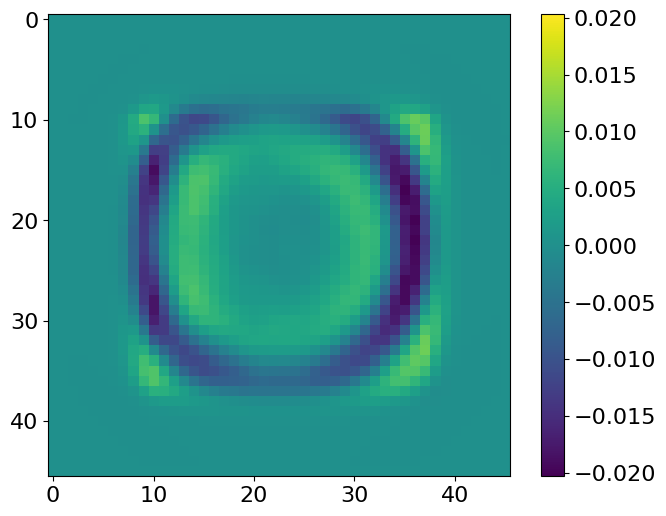

In [3]:
vmax = np.amax(np.absolute(model.τ[0, 0].data[-1, :, 15]))
plt.imshow(model.τ[0, 0].data[-1, :, 15].T, vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.show()

## Exercise: finish adding the free-surface treatment to the propagator class above

Hint: see [03_subdomains](https://github.com/devitocodes/devito/blob/master/examples/userapi/03_subdomains.ipynb) and [04_boundary_conditions](https://github.com/devitocodes/devito/blob/master/examples/userapi/04_boundary_conditions.ipynb) for examples on how to do this.